In [1]:
import os
import shutil
from pathlib import Path

import jax.random as jr
import jax.numpy as jnp
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.gaussian_obs import add0



In [2]:
def clean_dir(path):
    paths_to_remove = []
    _dir = Path(path)
    for i, exp in enumerate(_dir.glob('*')):
        exp_path = Path(exp)
        contents = []
        for f in exp_path.glob('*'):
            contents.append(os.path.split(f)[1])
        if 'res.pickle' not in contents: 
            shutil.rmtree(exp_path)
            print('Removing unfinished experiment')

def clean_temp(path):
    Lpaths = get_model_paths(10, 'true-init')
    results = {}
    for path in Lpaths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)
        obs_var = cfg.obs.ov2
        if 'support' not in list(cfg.model.keys()):
            print(cfg)
            # shutil.rmtree(path)
            print('Removing old experiment')
        # print(obs_var)
        # print(cfg)

        # res = pickle_open(os.path.join(path, 'res.pickle'))
        # res['cfg'] = cfg
        # results[obs_var] = res

In [3]:
def load_results(paths, **kwargs):
    Lpaths = get_model_paths(paths, **kwargs)
    results = {}
    for path in Lpaths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)
        obs_var = cfg.obs.ov2

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results[obs_var] = res
    return results

def get_model_paths(paths, **kwargs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if cfg.latent.L == L:
                if cfg.model.emiters == emiters:
                    if cfg.model.init == init:
                        if supp is not None:
                            if 'support' in list(cfg.model.keys()):
                                if cfg.model.support == supp:
                                        sel_paths.append(exp)
                        else:
                            if 'support' not in list(cfg.model.keys()):
                                if cfg.model.emiters == emiters:
                                    sel_paths.append(exp)
                            else:
                                if cfg.model.support == supp:
                                        sel_paths.append(exp)
    return sel_paths

In [4]:
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/outputs/2024-07-29', 
             '/projectnb/stephenlab/jtauber/cohlib/hydra/outputs/2024-07-30']

In [5]:
from cohlib.utils import gamma_root
def compute_naive_and_oracle(cfg):
    lcfg = cfg.latent
    ocfg = cfg.obs

    gamma_path = os.path.join(gamma_root(), f"{cfg.latent.gamma}.pickle")
    gamma_load = pickle_open(gamma_path)
    gamma_full = gamma_load['gamma']
    freqs = gamma_load['freqs']
    N = freqs.size
    nz = gamma_load['nonzero_inds']
    K = gamma_full.shape[-1]

    gamma_full *= lcfg.scale

    lrk = jr.key(lcfg.seed)
    zs = sample_from_gamma(lrk, gamma_full, lcfg.L)
    gamma_est_oracle = jnp.einsum('nkl,nil->nkil', zs, zs.conj()).mean(-1)



    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    ork = jr.key(ocfg.seed)


    obs_var = ocfg.ov1 * 10**ocfg.ov2
    obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

    obs_mc = obs - obs.mean(0)[None,:,:]
    obs_f = jnp.fft.rfft(obs_mc, axis=0)[1:,:,:]
    gamma_est_naive = jnp.einsum('nkl,nil->nkil', obs_f, obs_f.conj()).mean(-1)

    return gamma_est_oracle, gamma_est_naive

In [6]:
def pow(gamma, k, db=False, freq_inds=None):
    if freq_inds is None:
        freq_inds = jnp.arange(gamma.shape[0])
    S = gamma[freq_inds,k,k].real
    if db is True:
        S = 10*jnp.log10(S+1e-15)
    return S

In [7]:
gamma_name = 'k2-single-10'
gamma_path = os.path.join(gamma_root(), f"{gamma_name}.pickle")
gamma_load = pickle_open(gamma_path)
gamma_raw = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']

supp_full = [0, 50]
nz_fit50 = jnp.where((freqs >= supp_full[0]) & (freqs <= supp_full[1]))

In [8]:
L = 1000
init = 'flat-init'
emiters = 20

supp = [0, 50]
res_fit50 = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
supp = None
res_single = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)

scale = res_single[0]['cfg'].latent.scale
gamma_true = gamma_raw*scale
ovs = sorted(res_fit50.keys())

In [9]:
g = res_single[-5]['gamma']
from cohlib.mvcn import thr_coherence
thr_coherence(g)

array([0.06970828], dtype=float32)

In [10]:
thr_coherence(gamma_raw[nz,:,:])

array([0.08], dtype=float32)

In [13]:
emiters = 20
L = 50
db = True
k = 0
init = 'flat-init'

supp = [0, 50]
res_fit50 = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
supp = None
res_single = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)


fit50_targ = jnp.zeros(len(ovs))
fit50_offtarg = jnp.zeros(len(ovs))
single_targ = jnp.zeros(len(ovs))

oracle_targ = jnp.zeros(len(ovs))
oracle_offtarg = jnp.zeros(len(ovs))
naive_targ = jnp.zeros(len(ovs))
naive_offtarg = jnp.zeros(len(ovs))

tind = jnp.array([9])
otind = jnp.array([20])
tind_single = jnp.array([0])

true_targ = jnp.ones(len(ovs))*pow(gamma_true, k, db=db, freq_inds=tind)
for i, ov in enumerate(ovs):
    gamma_fit50_est = res_fit50[ov]['gamma']
    gamma_single_est = res_single[ov]['gamma']

    fit50_targ_power = pow(gamma_fit50_est, k, db=db, freq_inds=tind)
    fit50_targ = fit50_targ.at[i,].set(fit50_targ_power[0])

    fit50_offtarg_power = pow(gamma_fit50_est, k, db=db, freq_inds=otind)
    fit50_offtarg = fit50_offtarg.at[i,].set(fit50_offtarg_power[0])

    single_targ_power = pow(gamma_single_est, k, db=db, freq_inds=tind_single)
    single_targ = single_targ.at[i,].set(single_targ_power[0])


    gamma_oracle, gamma_naive = compute_naive_and_oracle(res_single[ov]['cfg'])

    oracle_targ_power = pow(gamma_oracle, k, db=db, freq_inds=tind)
    oracle_targ = oracle_targ.at[i,].set(oracle_targ_power[0])

    oracle_offtarg_power = pow(gamma_oracle, k, db=db, freq_inds=otind)
    oracle_offtarg = oracle_offtarg.at[i,].set(oracle_offtarg_power[0])

    naive_targ_power = pow(gamma_naive, k, db=db, freq_inds=tind)
    naive_targ = naive_targ.at[i,].set(naive_targ_power[0])

    naive_offtarg_power = pow(gamma_naive, k, db=db, freq_inds=otind)
    naive_offtarg = naive_offtarg.at[i,].set(naive_offtarg_power[0])


Text(0.5, 0, 'log10 obs var')

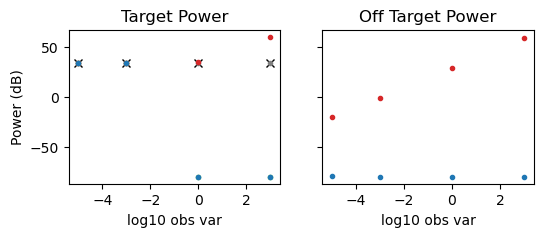

In [14]:
ylimu = 5000

fig, ax = plt.subplots(1,2,figsize=(6,2), sharex=True, sharey=True)
ax[0].plot(ovs, true_targ, 'x', color='k', linewidth=2, label='True')
ax[0].plot(ovs, oracle_targ, '.', color='tab:grey', label='Oracle')
ax[0].plot(ovs, single_targ, '.', color='tab:green', label='Model-single')
ax[0].plot(ovs, naive_targ, '.', color='tab:red', label='Naive')
ax[0].plot(ovs, fit50_targ, '.', color='tab:blue', label='Model-fit50')
ax[0].set_title('Target Power')
ax[1].set_title('Off Target Power')
if db is True:
    ax[0].set_ylabel('Power (dB)')
else:
    ax[0].set_ylabel('Power')
ax[0].set_xlabel('log10 obs var')
    

ax[1].plot(ovs, naive_offtarg, '.', color='tab:red', label='Naive')
ax[1].plot(ovs, fit50_offtarg, '.', color='tab:blue', label='Model-fit50')
ax[1].set_xlabel('log10 obs var')


# ax[0].set_ylim([-50,ylimu])
# ax[1].set_ylim([-50,ylimu])



In [65]:
res_fit50[-5]['cfg']

{'latent': {'gamma': 'k2-single-10', 'scale': 500, 'L': 1000, 'seed': 7}, 'obs': {'ov1': 1, 'ov2': -5, 'seed': 7}, 'model': {'init': 'true-init', 'maxiter': 5, 'emiters': 20, 'scale_init': 0.01, 'support': [0, 50]}}

In [66]:
res_fit50[-5]['gamma']

Array([[[ 4.7158942e-08+2.10536166e-21j,  9.5485375e-10+1.38905462e-13j],
        [ 9.5485375e-10-1.38905462e-13j,  4.1388901e-08+1.02341326e-21j]],

       [[ 3.6326597e-08+1.64807800e-21j,  1.8026443e-09-2.29580433e-13j],
        [ 1.8026443e-09+2.29580461e-13j,  4.2316426e-08+1.63637843e-21j]],

       [[ 4.5940499e-08+2.80944221e-21j, -3.8386050e-09+2.56380881e-13j],
        [-3.8386050e-09-2.56380881e-13j,  4.1696186e-08+3.53476127e-21j]],

       [[ 4.4119652e-08-1.38011491e-21j,  1.6110339e-09-2.16701978e-14j],
        [ 1.6110340e-09+2.16701995e-14j,  3.8019252e-08-1.01492517e-21j]],

       [[ 3.7180790e-08+2.50340760e-21j,  7.3234008e-10-1.97125289e-13j],
        [ 7.3234013e-10+1.97125302e-13j,  3.7932605e-08+2.85634210e-21j]],

       [[ 4.0449901e-08+7.05877161e-21j,  1.3706063e-09+4.11693588e-14j],
        [ 1.3706065e-09-4.11693554e-14j,  4.3757257e-08+8.14848513e-21j]],

       [[ 4.1149551e-08-2.06854203e-21j, -2.2449689e-09+7.75109482e-14j],
        [-2.2449691e-09-7.